In [1]:

from datetime import timedelta
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot
#from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from fbprophet import Prophet
import matrixprofile as mp

#from statsmodels.compat.numpy import NP_LT_123

/home/jonathan/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-09-05 20:27:08.620421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 20:27:08.620456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datos Tasa de Incidencia Covid

In [2]:
basepath = "/media/jonathan/JHON/Tesis/DatosTesis/Data_Covid19/covid19FEB_JUL.csv"
data = pd.read_csv(basepath, sep=';',dtype={"municipio_distrito": str,
                                        "tasa_incidencia_acumulada_ultimos_14dias": str,
                                        "tasa_incidencia_acumulada_total": str},parse_dates=['fecha_informe'],usecols=[0,1,3], encoding='latin-1')

data['TasaIncidenciaAcumulada_Ultimos14dias'] = [int(value.split(",",1)[0]) for value in data['tasa_incidencia_acumulada_ultimos_14dias']]
data['fecha_informe'] = data['fecha_informe'].apply(lambda x:x.replace(hour=0,minute=0))
data.set_index('fecha_informe', inplace = True)



basepath = "/media/jonathan/JHON/Tesis/DatosTesis/Data_Covid19/covid19JUL_2022.csv"
data2 = pd.read_csv(basepath, sep=';',dtype={"municipio_distrito": str,
                                        "tasa_incidencia_acumulada_ultimos_14dias": str,
                                        "tasa_incidencia_acumulada_total": str},parse_dates=['fecha_informe'],usecols=[0,1,5], encoding='latin-1')

data2['TasaIncidenciaAcumulada_Ultimos14dias'] = [int(value.split(",",1)[0]) for value in data2['tasa_incidencia_acumulada_ultimos_14dias']]
data2['fecha_informe'] = data2['fecha_informe'].apply(lambda x:x.replace(hour=0,minute=0))
data2.set_index('fecha_informe', inplace = True)

data2.head(2)

,municipio_distrito,tasa_incidencia_acumulada_ultimos_14dias,TasaIncidenciaAcumulada_Ultimos14dias
fecha_informe,,,
2022-03-29,Madrid-Retiro,"301,6",301
2022-03-29,Madrid-Salamanca,"266,5",266


# Tablas Tasa de Incidencia Covid

In [3]:
table = pd.pivot_table(data, values=["TasaIncidenciaAcumulada_Ultimos14dias"], index=["fecha_informe"], columns=["municipio_distrito"], aggfunc={"TasaIncidenciaAcumulada_Ultimos14dias":"first"})
table.head(5)

table2 = pd.pivot_table(data2, values=["TasaIncidenciaAcumulada_Ultimos14dias"], index=["fecha_informe"], columns=["municipio_distrito"], aggfunc={"TasaIncidenciaAcumulada_Ultimos14dias":"first"})
table2.head(5)

table = table.astype(np.float64)
table2 = table2.astype(np.float64)

#Quitamos los niveles sobrantes del nivel superior y reiniciamos index - Solo se hace una vez de lo contrario genera problema
table.columns =[str(s2) for (s1,s2) in table.columns.tolist()]
table_Final = table.reset_index()
table_Final.set_index('fecha_informe', inplace = True)

table2.columns =[str(s2) for (s1,s2) in table2.columns.tolist()]
table2_Final = table2.reset_index()
table2_Final.set_index('fecha_informe', inplace = True)

#table.dtypes
#table.iloc[120:127,97:115]
table_Final.head(2)

,Ajalvir,Alameda del Valle,Alcalá de Henares,Alcobendas,Alcorcón,Aldea del Fresno,Algete,Alpedrete,Ambite,Anchuelo,...,Villamanta,Villamantilla,Villanueva de Perales,Villanueva de la Cañada,Villanueva del Pardillo,Villar del Olmo,Villarejo de Salvanés,Villaviciosa de Odón,Villavieja del Lozoya,Zarzalejo
fecha_informe,,,,,,,,,,,,,,,,,,,,,
2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Procesamiento datos desplazamiento por trayecto

In [4]:
def df_origen(origen,destino):     
    
    ######################PICKLE###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)

    df = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)    
    
    ######################PICKLE 1###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento1.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df1 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento1.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 2###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df2 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 3###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento3.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df3 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento3.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 4###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento4.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df4 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento4.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 5###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento5.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df5 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento5.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    ######################PICKLE 6###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento6.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df6 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento6.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    #Filtramos el destino
    columns_names_df = df.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)    
    
    #Cambiamos el nombre de las columnas
    lines_names = {"19024":"Fuera_Madrid","2800601":"Fuera_Madrid","2806504":"Fuera_Madrid","2807901":"Centro","2807902":"Arganzuela","2807903":"Retiro","2807904":"Salamanca","2807905":"Chamartín","2807906":"Tetuán","2807907":"Chamberí","2807908":"El_Pardo","2807909":"Moncloa-Aravaca","2807910":"Latina","2807911":"Carabanchel","2807912":"Usera","2807913":"Puente_de_Vallecas","2807914":"Moratalaz","2807915":"Ciudad_Lineal","2807916":"Hortaleza","2807917":"Villaverde","2807918":"Villa_de_Vallecas","2807919":"Vicálvaro","2807920":"San Blas-Canillejas","2812301":"Fuera_Madrid","2807921":"Barajas"}            
    df_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df_Final['Fecha'] = df_Final.index.date
    df_Final['Año'] = df_Final.index.year                                
    df_Final['Mes'] = df_Final.index.month                               
    df_Final['ID_Dia'] = df_Final.index.dayofweek
    df_Final['Hora'] = df_Final.index.hour
    df_Final['WeekNo'] = df_Final.index.isocalendar().week
    df_Final[lines_names[origen]] = table_Final["Madrid"+"-"+lines_names[origen]].loc['2020-02-14':'2020-03-16']
    df_Final[lines_names[destino]] = table_Final["Madrid"+"-"+lines_names[destino]].loc['2020-02-14':'2020-03-16']
          
    
    #Filtramos el destino
    columns_names_df = df1.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df1_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento1.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df1_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df1_Final['Fecha'] = df1_Final.index.date
    df1_Final['Año'] = df1_Final.index.year                                
    df1_Final['Mes'] = df1_Final.index.month                               
    df1_Final['ID_Dia'] = df1_Final.index.dayofweek
    df1_Final['Hora'] = df1_Final.index.hour
    df1_Final['WeekNo'] = df1_Final.index.isocalendar().week
    df1_Final[lines_names[origen]] = table_Final["Madrid"+"-"+lines_names[origen]].loc['2020-03-17':'2020-05-31']    
    df1_Final[lines_names[destino]] = table_Final["Madrid"+"-"+lines_names[destino]].loc['2020-03-17':'2020-05-31']    

    #Filtramos el destino
    columns_names_df = df2.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df2_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df2_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df2_Final['Fecha'] = df2_Final.index.date
    df2_Final['Año'] = df2_Final.index.year                                
    df2_Final['Mes'] = df2_Final.index.month                               
    df2_Final['ID_Dia'] = df2_Final.index.dayofweek
    df2_Final['Hora'] = df2_Final.index.hour
    df2_Final['WeekNo'] = df2_Final.index.isocalendar().week   
    df2_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-06-01':'2020-07-31']
    df2_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-06-01':'2020-07-31']
    
    
    #Filtramos el destino
    columns_names_df = df3.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df3_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento3.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df3_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df3_Final['Fecha'] = df3_Final.index.date
    df3_Final['Año'] = df3_Final.index.year                                
    df3_Final['Mes'] = df3_Final.index.month                               
    df3_Final['ID_Dia'] = df3_Final.index.dayofweek
    df3_Final['Hora'] = df3_Final.index.hour
    df3_Final['WeekNo'] = df3_Final.index.isocalendar().week
    df3_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-08-01':'2020-10-31']
    df3_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-08-01':'2020-10-31']
    
    
    #Filtramos el destino
    columns_names_df = df4.columns   
    names_1 = list(columns_names_df)    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
    df4_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento4.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)
    
    #Cambiamos el nombre de las columnas    
    df4_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df4_Final['Fecha'] = df4_Final.index.date
    df4_Final['Año'] = df4_Final.index.year                                
    df4_Final['Mes'] = df4_Final.index.month                               
    df4_Final['ID_Dia'] = df4_Final.index.dayofweek
    df4_Final['Hora'] = df4_Final.index.hour
    df4_Final['WeekNo'] = df4_Final.index.isocalendar().week   
    df4_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2020-11-01':'2020-12-31']
    df4_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2020-11-01':'2020-12-31']
    
    
    #Filtramos el destino
    columns_names_df = df5.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df5_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento5.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)    
    
    #Cambiamos el nombre de las columnas    
    df5_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df5_Final['Fecha'] = df5_Final.index.date
    df5_Final['Año'] = df5_Final.index.year                                
    df5_Final['Mes'] = df5_Final.index.month                               
    df5_Final['ID_Dia'] = df5_Final.index.dayofweek
    df5_Final['Hora'] = df5_Final.index.hour
    df5_Final['WeekNo'] = df5_Final.index.isocalendar().week    
    df5_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2021-01-01':'2021-01-31']
    df5_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2021-01-01':'2021-01-31']
    

    #Filtramos el destino
    columns_names_df = df6.columns   
    names_1 = list(columns_names_df)   
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)            
    df6_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento6.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)        
    
    #Cambiamos el nombre de las columnas    
    df6_Final.columns = [lines_names[origen]+"_"+lines_names[destino]]    
    
    #Añadimos columnas al Dataframe
    df6_Final['Fecha'] = df6_Final.index.date
    df6_Final['Año'] = df6_Final.index.year                                
    df6_Final['Mes'] = df6_Final.index.month                               
    df6_Final['ID_Dia'] = df6_Final.index.dayofweek
    df6_Final['Hora'] = df6_Final.index.hour
    df6_Final['WeekNo'] = df6_Final.index.isocalendar().week  
    df6_Final[lines_names[origen]] = table2_Final["Madrid"+"-"+lines_names[origen]].loc['2021-02-01':'2021-05-09']
    df6_Final[lines_names[destino]] = table2_Final["Madrid"+"-"+lines_names[destino]].loc['2021-02-01':'2021-05-09']
    
    
    return df_Final, df1_Final, df2_Final, df3_Final, df4_Final, df5_Final, df6_Final, listaDst

origen = "2807905"
destino = "2807901"
df_Final, df1_Final, df2_Final, df3_Final, df4_Final, df5_Final, df6_Final, listaDst = df_origen(origen,destino)
df_Final.tail(2)

,Chamartín_Centro,Fecha,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
ds,,,,,,,,,
2020-03-16 22:00:00,55.801,2020-03-16,2020,3,0,22,12,NaN,NaN
2020-03-16 23:00:00,21.306,2020-03-16,2020,3,0,23,12,NaN,NaN


In [5]:
#df6_Final[2040:2100]

In [6]:
#table2_Final.iloc[:50,88:200]
#table_Final.iloc[0:50,88:200]

In [7]:
#df_Final.iloc[288:348]

In [8]:
df_Final.isnull().sum()

Chamartín_Centro      0
Fecha                 0
Año                   0
Mes                   0
ID_Dia                0
Hora                  0
WeekNo                0
Chamartín           748
Centro              748
dtype: int64

In [9]:
def completar_datos(dataframe1):
    ##################### Completar penúltima Columna ###############################
    Distrito=dataframe1.columns[7]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición     
            Inc = 0                        

        dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') #Rango de fechas 24 horas  
        
        #Reemplazamos cada celda que posea NaN por el valor capturado a las 0 Horas             
        for date2 in dates_range2[1:-1]:            
            dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date2),Distrito] = Inc    
        cont=cont+24

        if cont1 < len(dates_range)-2: 
            cont1=cont1+1
            cont2=cont2+1
    #último Rango de fecha faltante
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[1:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc

    ##################### Completar última Columna ###############################    
    Distrito=dataframe1.columns[8]
    cont=0
    cont1=0
    cont2=1
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final)
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]

        if np.isnan(Inc):        
            Inc = 0                        

        dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H')    
        for date2 in dates_range2[1:-1]:                
            dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date2),Distrito] = Inc    
        cont=cont+24

        if cont1 < len(dates_range)-2: 
            cont1=cont1+1
            cont2=cont2+1

    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[1:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc
    dataframe1 = dataframe1.fillna(0)
    
    return dataframe1

In [10]:
def completar_datos2(dataframe1):
    ##################### Completar penúltima Columna ###############################
    Distrito=dataframe1.columns[7]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    week=[1,2,3,4,5,6,7]
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición             
            cont=cont+24
            
            if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
        if np.isnan(Inc)!=True:            
            dates_range_week = []
            if cont+168 <= len(dataframe1.index):
                cont=cont+168            
            else:
                cont=cont+(len(dataframe1.index)-cont)                
                
            for dia in week:
                dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') 
                dates_range_week.extend(list(dates_range2[0:-1]))               
                
                if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
            for datew in dates_range_week:                
                dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==datew),Distrito] = Inc                                           
            
                
            if cont == len(dataframe1.index):
                break
                
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[0:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc       
            

    ##################### Completar última Columna ###############################    
    Distrito=dataframe1.columns[8]  #Seleccionamos la penultima columna del df
    cont=0
    cont1=0
    cont2=1
    week=[1,2,3,4,5,6,7]
    inicio=dataframe1.index[0]
    final=dataframe1.index[-1]
    dates_range = pd.date_range(start=inicio,end=final) #Creamos un rango de fechas para iterar cada día
    
    for date in dates_range:
        Inc = dataframe1.iloc[cont][Distrito]   #Guardamos el primera celda de cada día a las 0 horas

        if np.isnan(Inc):   #Si hay un NaN entra condición             
            cont=cont+24
            
            if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
        if np.isnan(Inc)!=True:            
            dates_range_week = []
            if cont+168 <= len(dataframe1.index):
                cont=cont+168            
            else:
                cont=cont+(len(dataframe1.index)-cont)                
                
            for dia in week:
                dates_range2 = pd.date_range(start=dates_range[cont1],end=dates_range[cont2],freq='1H') 
                dates_range_week.extend(list(dates_range2[0:-1]))               
                
                if cont1 < len(dates_range)-2: 
                    cont1=cont1+1
                    cont2=cont2+1
                    
            for datew in dates_range_week:                
                dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==datew),Distrito] = Inc                                           
            
                
            if cont == len(dataframe1.index):
                break
                
    new_date= dates_range[cont2]+timedelta(days=1)    
    dates_range3 = pd.date_range(start=dates_range[cont2],end=new_date,freq='1H')    
    for date3 in dates_range3[0:-1]:    
        dataframe1.loc[(dataframe1[Distrito].isnull())  & (dataframe1.index==date3),Distrito] = Inc   
    dataframe1 = dataframe1.fillna(0)
    
    return dataframe1

In [11]:
df_Final = completar_datos(df_Final)
df1_Final = completar_datos(df1_Final)
df2_Final = completar_datos2(df2_Final)
df3_Final = completar_datos2(df3_Final)
df4_Final = completar_datos2(df4_Final)
df5_Final = completar_datos2(df5_Final)
df6_Final = completar_datos2(df6_Final)

In [12]:
#df1_Final.iloc[:-1]
#df_Final.iloc[500:-20]

# Comprobamos nuevamente si existen datos incompletos

In [13]:
print(df_Final.isnull().sum())
print(df1_Final.isnull().sum())
print(df2_Final.isnull().sum())
print(df3_Final.isnull().sum())
print(df4_Final.isnull().sum())
print(df5_Final.isnull().sum())
print(df6_Final.isnull().sum())

Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Chamartín           0
Centro              0
dtype: int64
Chamartín_Centro    0
Fecha               0
Año                 0
Mes                 0
ID_Dia              0
Hora                0
WeekNo              0
Ch

# Periodo de Desescalada

In [14]:
period1 = df1_Final.loc['2020-05-02':'2020-05-31']
period2 = df2_Final.loc['2020-06-01':'2020-06-08']
desescalada = pd.concat([period1,period2])
desescalada.tail()

,Chamartín_Centro,Fecha,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
ds,,,,,,,,,
2020-06-08 19:00:00,505.848,2020-06-08,2020,6,0,19,24,29.0,20.0
2020-06-08 20:00:00,501.923,2020-06-08,2020,6,0,20,24,29.0,20.0
2020-06-08 21:00:00,289.255,2020-06-08,2020,6,0,21,24,29.0,20.0
2020-06-08 22:00:00,305.953,2020-06-08,2020,6,0,22,24,29.0,20.0
2020-06-08 23:00:00,173.186,2020-06-08,2020,6,0,23,24,29.0,20.0


In [15]:
desescalada.describe()

,Chamartín_Centro,Año,Mes,ID_Dia,Hora,WeekNo,Chamartín,Centro
count,912.000000,912.0,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000
mean,163.767656,2020.0,5.210526,3.052632,11.500000,20.921053,37.815789,27.631579
std,125.921238,0.0,0.407906,2.065203,6.925985,1.596620,24.120286,18.148921
min,0.000000,2020.0,5.000000,0.000000,0.000000,18.000000,0.000000,0.000000
25%,52.944500,2020.0,5.000000,1.000000,5.750000,20.000000,21.000000,15.000000
50%,138.537000,2020.0,5.000000,3.000000,11.500000,21.000000,29.000000,20.000000
75%,243.940000,2020.0,5.000000,5.000000,17.250000,22.000000,62.000000,36.000000
max,621.987000,2020.0,6.000000,6.000000,23.000000,24.000000,87.000000,82.000000


<AxesSubplot:>

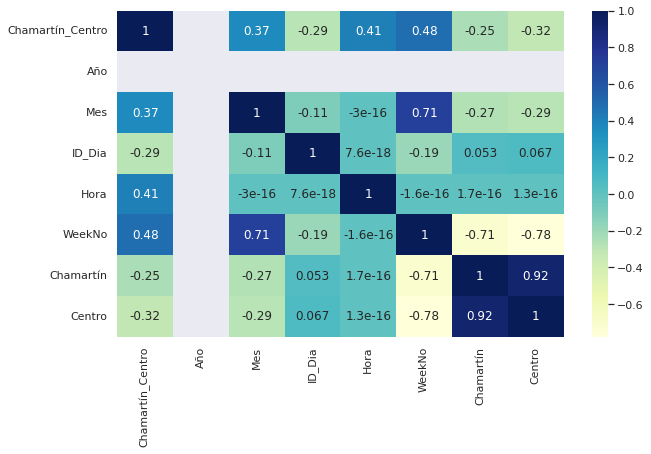

In [16]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(desescalada.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

In [17]:
desescalada.drop(columns=["Año","Mes","WeekNo"])
#desescalada.drop(desescalada.ID_Dia[5,6])
saturday=desescalada[desescalada["ID_Dia"]==5].index
sunday=desescalada[desescalada["ID_Dia"]==6].index
desescalada=desescalada.drop(saturday)
desescalada=desescalada.drop(sunday)

## Correlación de desplazamientos con los datos Covid

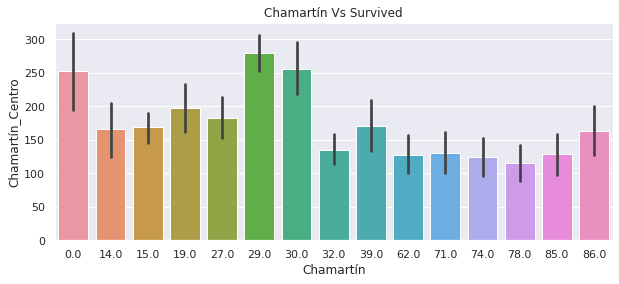

,Chamartín,Chamartín_Centro
5,29.000000,279.395633
6,30.000000,256.383021
0,0.000000,253.235042
3,19.000000,198.281604
4,27.000000,182.978354
8,39.000000,171.348292
2,15.000000,168.778625
1,14.000000,165.866375
14,86.000000,163.193250
7,32.000000,135.070819


In [18]:
def survived_bar_plot(feature):
    plt.figure(figsize = (10,4))
    sns.barplot(data = desescalada , x = feature , y = "Chamartín_Centro").set_title(f"{feature} Vs Survived")
    plt.show()
def survived_table(feature):
    return desescalada[[feature, "Chamartín_Centro"]].groupby([feature], as_index=False).mean().sort_values(by='Chamartín_Centro', ascending=False).style.background_gradient(low=0.75,high=1)
def survived_hist_plot(feature):
    plt.figure(figsize = (6,4))
    sns.histplot(data = desescalada , x = feature , hue = "Chamartín_Centro",binwidth=5 ,multiple = "stack" ).set_title(f"{feature} Vs Survived")
    plt.show()
    
survived_bar_plot('Chamartín')
survived_table("Chamartín")

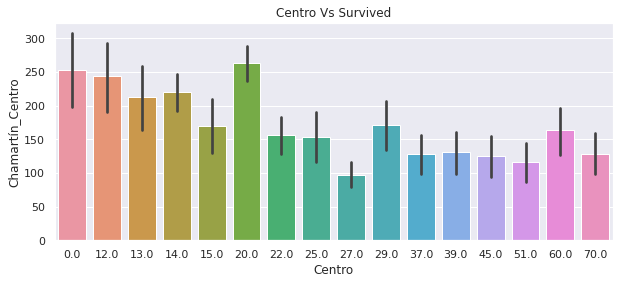

,Centro,Chamartín_Centro
5,20.000000,263.345104
0,0.000000,253.235042
1,12.000000,244.609667
3,14.000000,220.536594
2,13.000000,212.277542
9,29.000000,171.348292
4,15.000000,169.836500
14,60.000000,163.193250
6,22.000000,155.918771
7,25.000000,153.679167


In [19]:
survived_bar_plot('Centro')
survived_table("Centro")

## Correlación del día con el número de desplazamientos

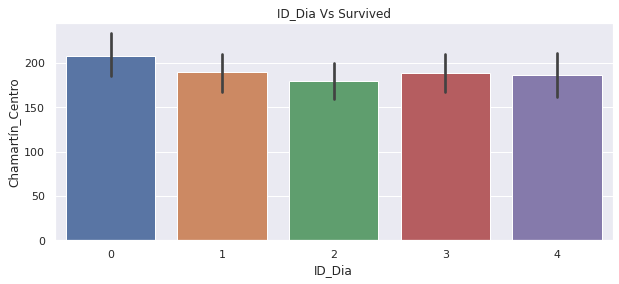

,ID_Dia,Chamartín_Centro
0,0,207.620597
1,1,189.463617
3,3,188.444217
4,4,186.827367
2,2,179.084408


In [20]:
survived_bar_plot('ID_Dia')
survived_table("ID_Dia")

## Correlación de la Hora con el número de esplazamientos

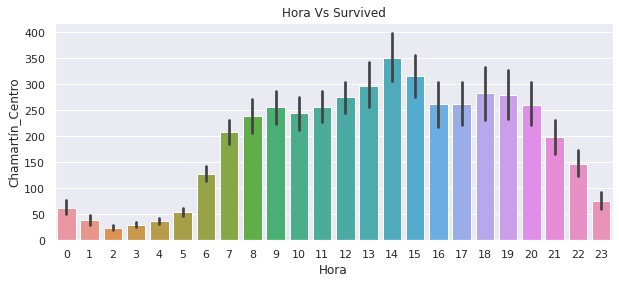

,Hora,Chamartín_Centro
14,14,350.494500
15,15,315.549462
13,13,295.794577
18,18,282.635731
19,19,279.427962
12,12,275.565115
17,17,262.793731
16,16,262.286808
20,20,260.648308
9,9,256.329962


In [21]:
survived_bar_plot('Hora')
survived_table("Hora")

/home/jonathan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


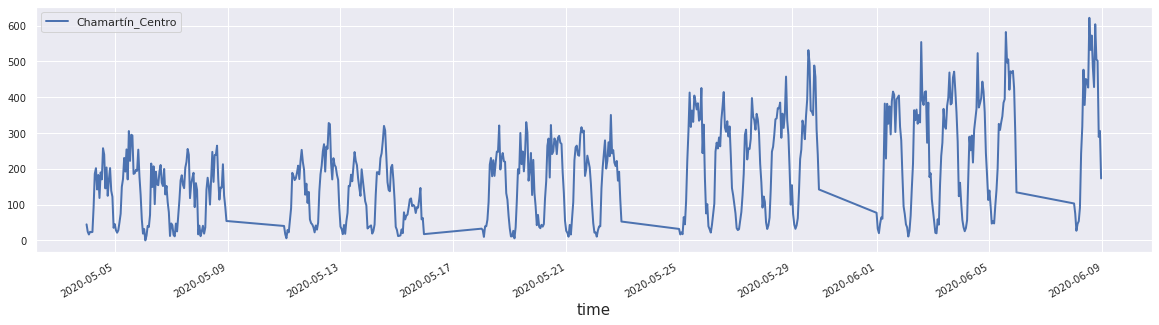

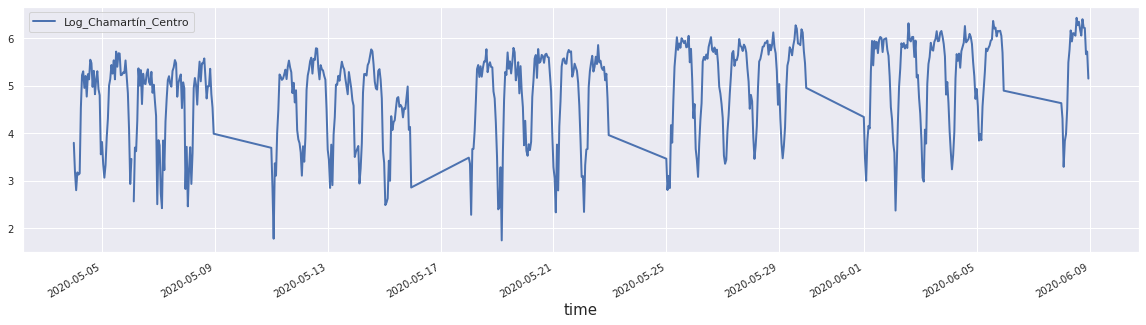

In [22]:
desescalada['Log_Chamartín_Centro']=np.log(desescalada['Chamartín_Centro'])
desescalada.head()

desescalada[['Chamartín_Centro']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);
desescalada[['Log_Chamartín_Centro']].plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=15);

# Estacionalidad
## Al observar la estacionalidad se observa que la serie tiene un marcado componente estacional, que consiste en un aumento de los desplazamientos cada 24 horas. 

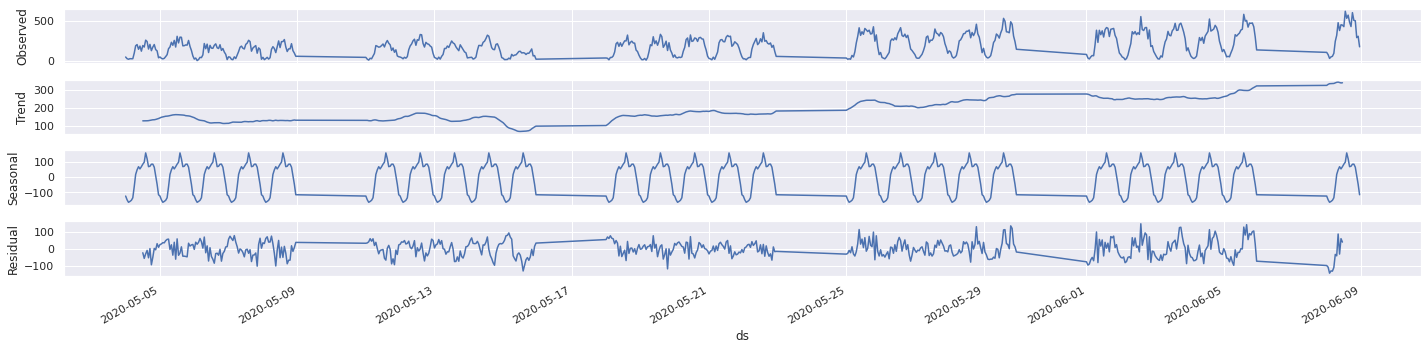

In [23]:
res = seasonal_decompose(desescalada["Chamartín_Centro"], model='additive',period=24)

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

# Análisis de la Estacionariedad 
## Se desea una serie estacionaria 
##   Cuando la serie no es estacionaria en varianza se requiere una transformación logarítmica

In [24]:
desplazamientos=desescalada['Chamartín_Centro']
Log_desplazamientos=desescalada['Log_Chamartín_Centro']

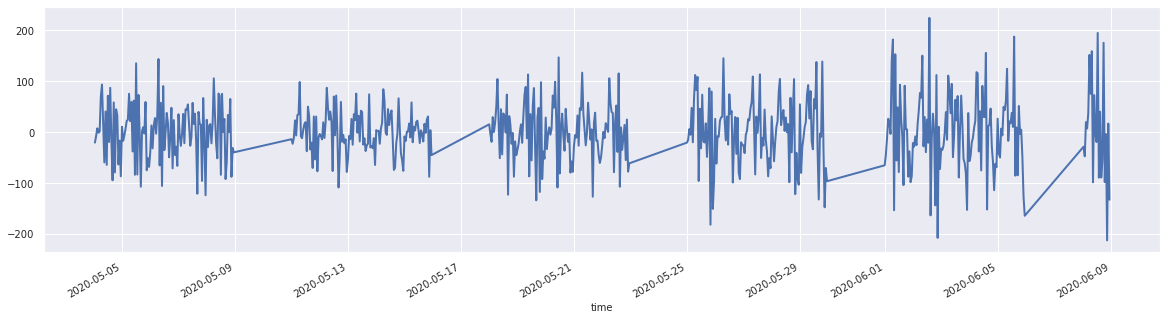

In [25]:
#Primera diferencia de la serie (niveles)
desplazamientos.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=10);

## Al aplicar la transformacíon logaritmica se está eliminando la tendencia, por lo que el analisis de la serie se realizará con la serie en logaritmo.

<AxesSubplot:xlabel='ds'>

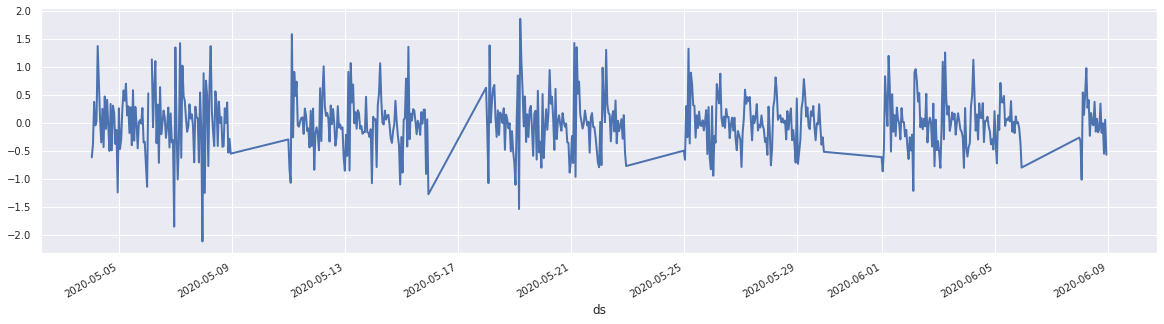

In [26]:
#Primera diferencia de la serie (logaritmo)
Log_desplazamientos.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)

## Prueba de Dickey- Fuller para realizar una verificación formal de la estacionariedad de la serie.

### Los resultados de la prueba de Dickey- Fuller indican que la serie es NO estacionaria en un porcentaje mayor a 10%

In [27]:
result = adfuller(desescalada['Chamartín_Centro'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.153868
p-value: 0.693119
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


/home/jonathan/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jonathan/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jonathan/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

Text(0, 0.5, 'Número de desplazamientos')

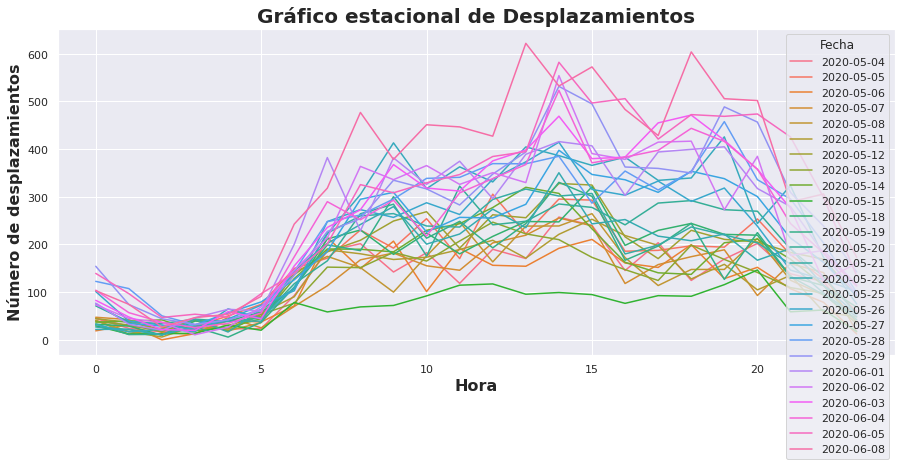

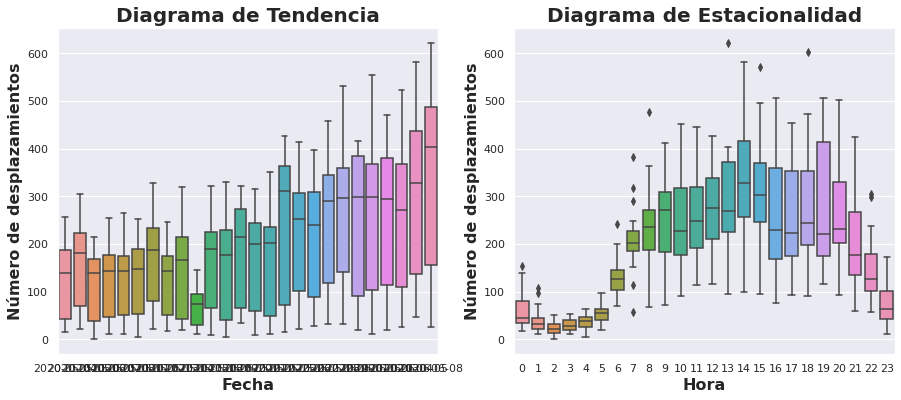

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))

#palette = sns.color_palette("ch:2.5,-.2,dark=.3", 7)
palette = sns.color_palette("hls", 7)
sns.lineplot(desescalada['Hora'], desescalada['Chamartín_Centro'], hue=desescalada['Fecha'])#, palette=palette)
ax.set_title('Gráfico estacional de Desplazamientos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Hora', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Número de desplazamientos', fontsize = 16, fontdict=dict(weight='bold'))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(desescalada['Fecha'], desescalada['Chamartín_Centro'], ax=ax[0])
ax[0].set_title('Diagrama de Tendencia', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Fecha', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Número de desplazamientos', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(desescalada['Hora'], desescalada['Chamartín_Centro'], ax=ax[1])
ax[1].set_title('Diagrama de Estacionalidad', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Hora', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Número de desplazamientos', fontsize = 16, fontdict=dict(weight='bold'))


In [29]:
windows = [
    ('4 Hours', 4),
    ('8 Hours', 8),
    ('12 Hours', 12),
    ('24 Hours', 24),
    ('7 Days', 7 * 24),
    #('30 Days', 30 * 24),
]

profiles = {}

for label, window_size in windows:
    profile = mp.compute(desescalada['Chamartín_Centro'].values, window_size)
    key = '{} Profile'.format(label)
    profiles[key] = profile

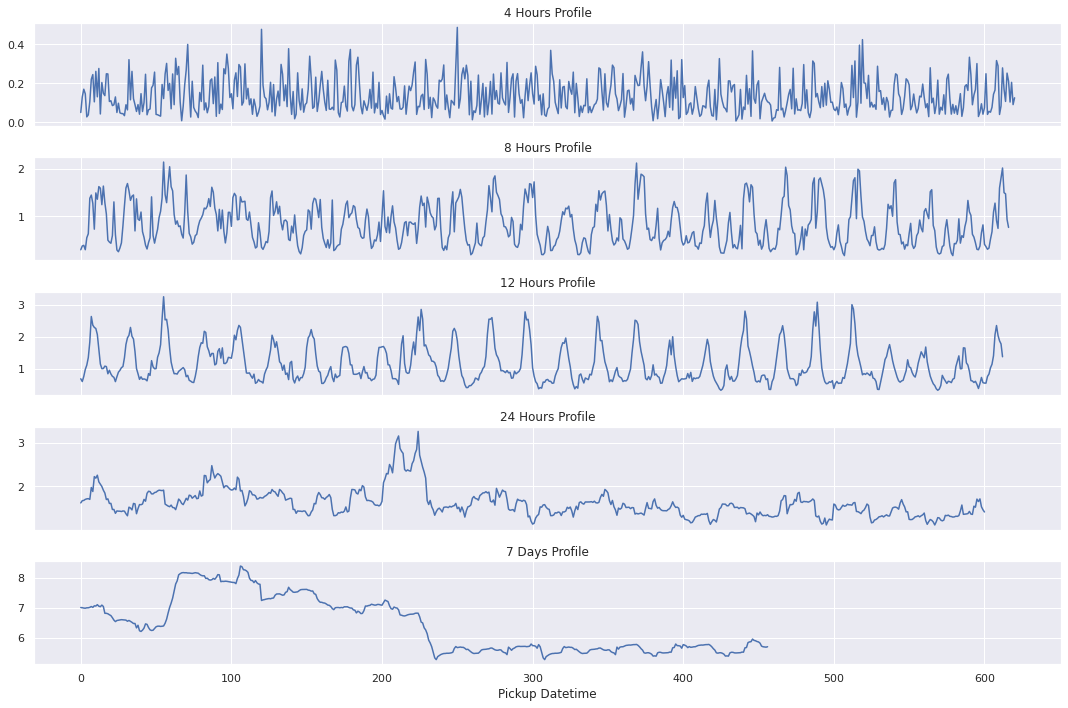

In [30]:
#Plot the signal data
fig, axes = plt.subplots(5,1,sharex=True,figsize=(15,10))

for ax_idx, window in enumerate(windows):
    key = '{} Profile'.format(window[0])
    profile = profiles[key]
    axes[ax_idx].plot(profile['mp'])
    axes[ax_idx].set_title(key)

plt.xlabel('Pickup Datetime')
plt.tight_layout()
plt.show()

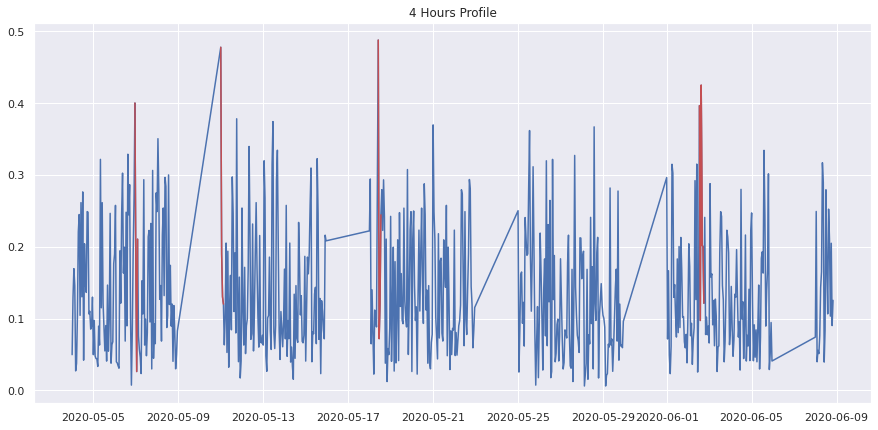

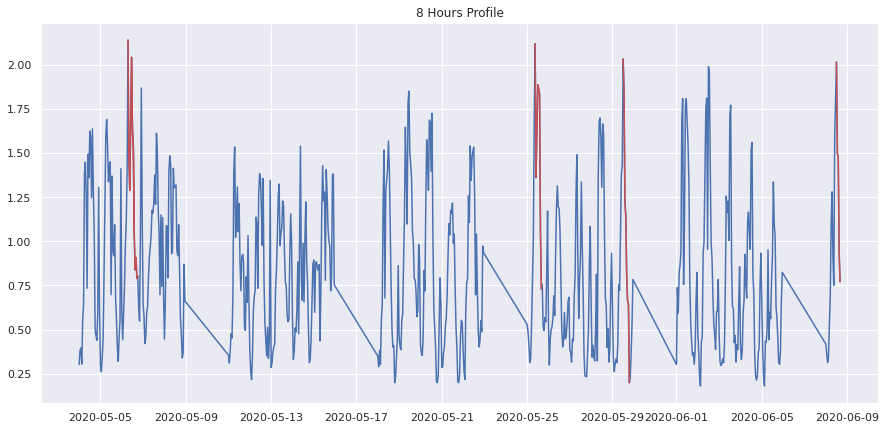

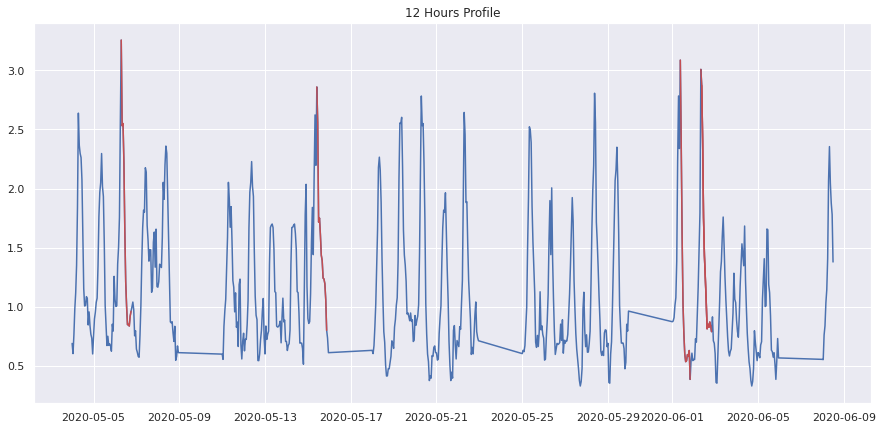

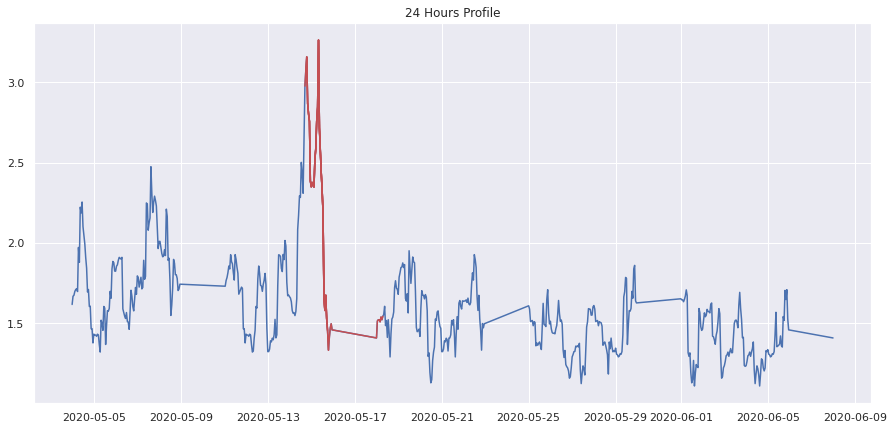

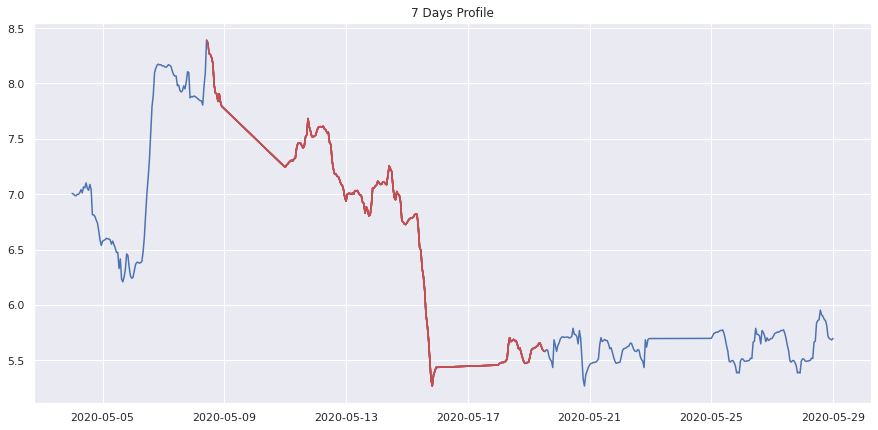

In [31]:
for label, window_size in windows:
    key = '{} Profile'.format(label)
    profiles[key] = mp.discover.discords(profiles[key], k=5)
    
    window_size = profiles[key]['w']
    mp_adjusted = np.append(profiles[key]['mp'], np.zeros(window_size - 1) + np.nan)
    
    plt.figure(figsize=(15, 7))
    ax = plt.plot(desescalada.index.values, mp_adjusted)
    plt.title(key)
    
    for start_index in profiles[key]['discords']:
        x = desescalada.index.values[start_index:start_index+window_size]
        y = mp_adjusted[start_index:start_index+window_size]
        plt.plot(x, y, c='r')
    
    plt.show()
